<a href="https://colab.research.google.com/github/venkateswarisamani/FMML-LABS/blob/main/FMML_Course_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 1 - Introduction to Probability Theory

Lab by V Vijay Vignesh

vijay.vignesh@research.iiit.ac.in

In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
plt.style.use('ggplot')

## Visualizing Gaussian Distribution Functions

Most measurements of real valued quantities can be reasonably modelled with Gaussian distributions, so they are ubiquitous in Bayesian models. Let's take a look and get a feel of the structure of these distributions and how they work in higher dimentional spaces.

Let's first take a look at the Gaussian distribution changing with change in parameters. The following 2 visualizations show the change of the gaussian with the mean and variance.

### 1D Gaussians, Mean and Variance

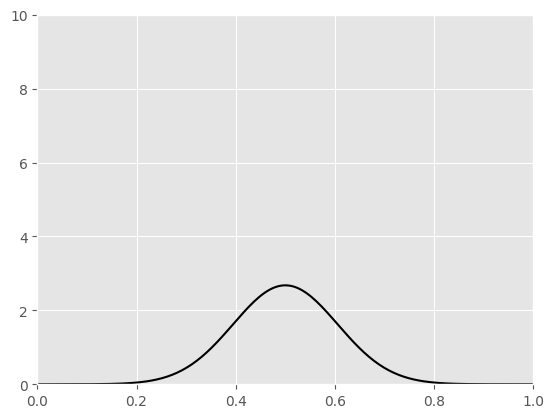

In [3]:
import math
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='jshtml')


def gaussian_pdf(x, a, b):
    return (1 / np.sqrt(2 * np.pi * b * b))* np.exp(-(x - a)**2 / (b ** 2))

class UpdateDist:

    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            self.mean = 0.5
            self.var = 0.050
            self.line.set_data([], [])
            return self.line,

        # Choose success based on exceed a threshold with a uniform pick
        self.var += 0.001
        y = gaussian_pdf(self.x, self.mean, self.var)
        self.line.set_data(self.x, y)
        return self.line,


fig, ax = plt.subplots()
ud = UpdateDist(ax)
anim = FuncAnimation(fig, ud, frames=100, interval=200, blit=True)

anim

In [ ]:
import math
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='jshtml')


def gaussian_pdf(x, a, b):
    return (1 / np.sqrt(2 * np.pi * b * b))* np.exp(-(x - a)**2 / (b ** 2))

class UpdateDist:

    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            self.mean = 0.1
            self.var = 0.050
            self.line.set_data([], [])
            return self.line,

        # Choose success based on exceed a threshold with a uniform pick
        self.mean += 0.01
        y = gaussian_pdf(self.x, self.mean, self.var)
        self.line.set_data(self.x, y)
        return self.line,


fig, ax = plt.subplots()
ud = UpdateDist(ax)
anim = FuncAnimation(fig, ud, frames=100, interval=200, blit=True)

anim

### Higher Dimentional Plots

Following is an interactive plot of a 2D Gaussian. The plot is in 3D, since the 3rd axis represents the value of the Gaussian as a function of the first two variables.
**Hover your mouse on the Gaussian, you can see the contours of the 2 marginal 1-D Gaussians.**

In [ ]:
scan = np.linspace(-200, 200, 500)
x, y = np.meshgrid(scan, scan)
z = np.exp(-(x ** 2 + y ** 2) / (70.0) ** 2)

fig = pg.Figure(data=[pg.Surface(x=y, y=x, z=z)])
fig.update_traces(contours_z=dict(show=True,
                                    usecolormap=True,
                                    highlightcolor="limegreen",
                                    project_z=True))
fig.update_layout(title="2D Gaussian", autosize=False,
                    scene_camera_eye=dict(x=1.5, y=-1.5, z=1.5),
                    width=1200, height=600,
                    margin=dict(l=50, r=50, b=50, t=50))
fig.show()

In [ ]:
x, y, z = np.random.normal(size=10000), np.random.normal(size=10000), np.random.normal(size=10000)
v = np.exp(-(x ** 2 + y ** 2 + z ** 2) / (70.0) ** 2)

fig = pg.Figure(data=[pg.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color=v,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


## Basics of Bayes - Librarian or Farmer?

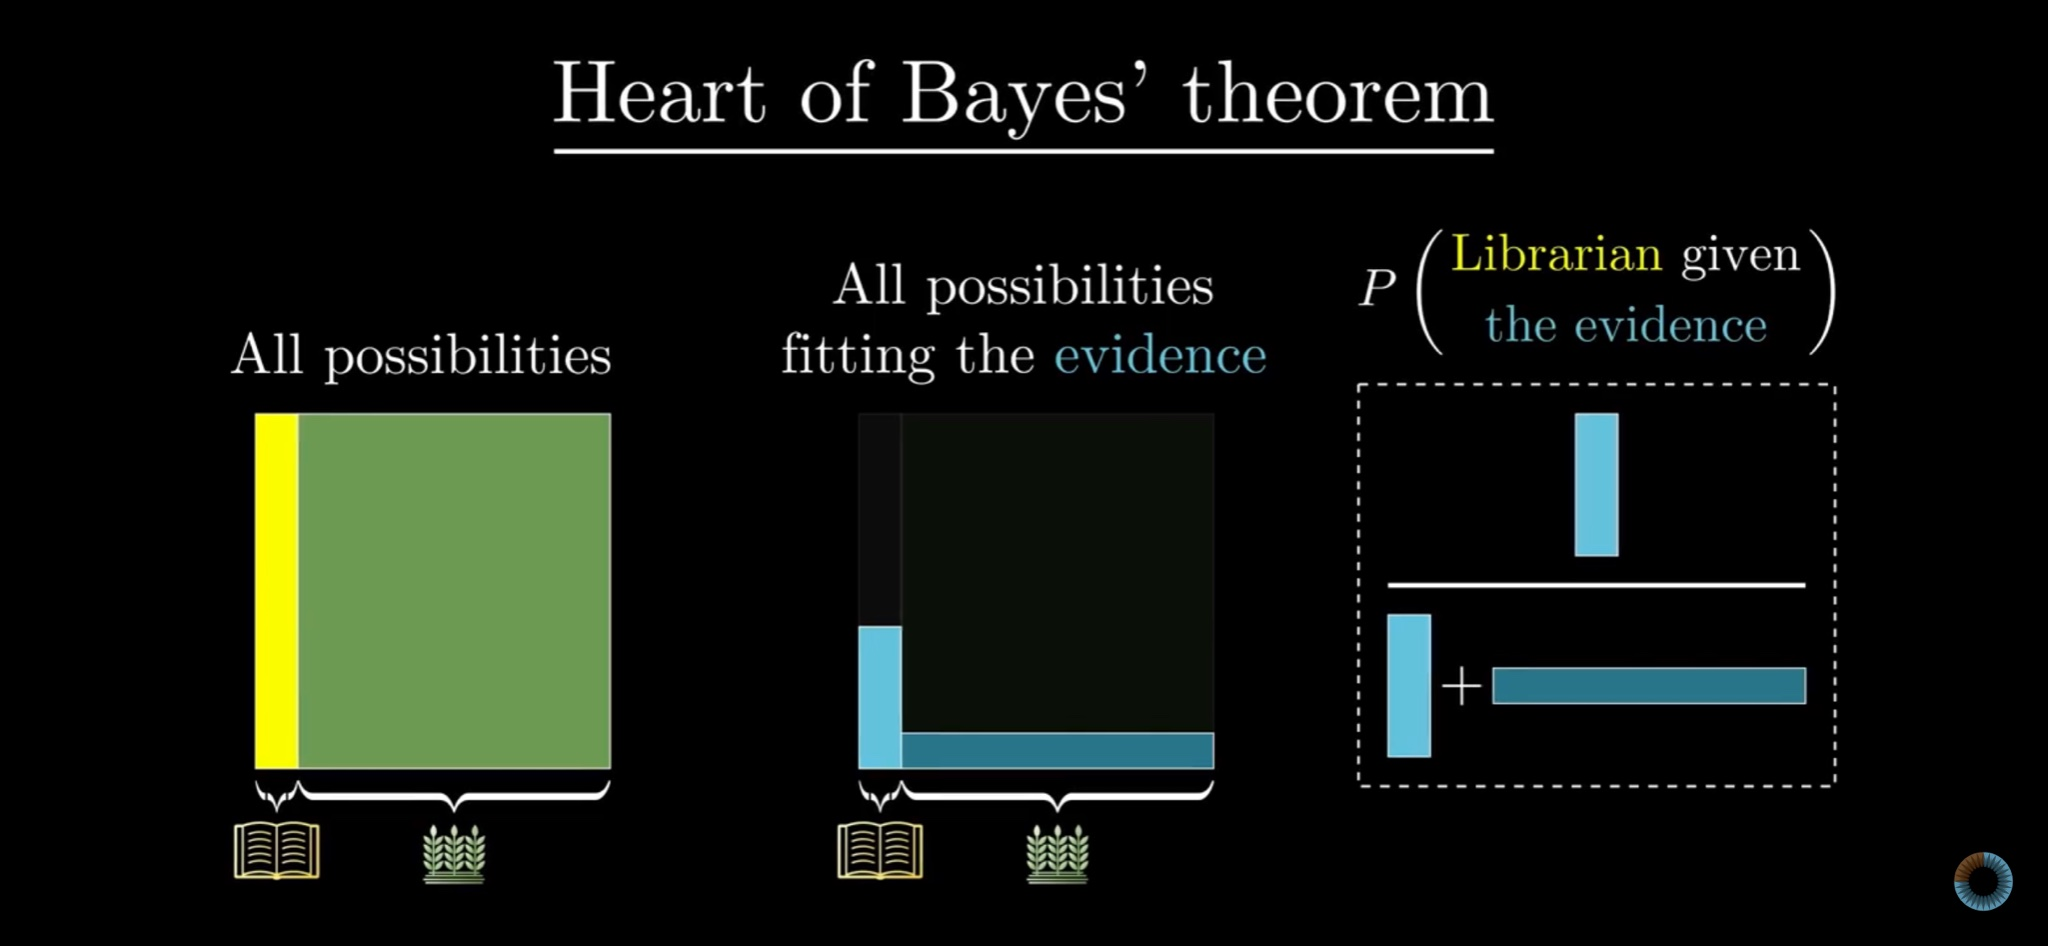

### Bayes Rule

$$P(A|X)=\frac{P(X|A)P(A)}{P(X|A)P(A)+ P(X|\bar{A})P(\bar{A})}$$

Following is the mathematical description of Bayes theorem, described by the figure above:

$$ P(A|X) = \frac{P(X | A) P(A) }{P(X) } $$

Often, computing the denominator $P(X)$ is not feasible. This is because $\sum_{a \in A} P(X | A) P(A) $ is the way to compute the normalizing factor, also called the likelihood, but the number of terms that add up to this likelihood is the entire event space in $A$. This event space may usually be huge or even infinite, converting the sum into an integral which is hard to evaluate.

To avoid the problem of computing the likelihood, we choose to live with unnormalized distributions, i.e. a Probability distribution which does not sum upto 1. The true probabilities are proportional to this value. The proportionality form of Bayes rule is given below.
$$ P(A|X) \propto{P(X | A) P(A) } $$


In [7]:
strong_farmers = 180
weak_farmers = 20
strong_librarians = 6
weak_librarians = 4

### Likelihood of being a Librarian based on traits

Let's take a small example. We have a person, who our friend has described as a person who likes to sit at his desk, and doesn't engage in shows of strength. You have to guess whether this person is a farmer of a librarian (he is guarenteed to be one of these).

Most people think that given the description, this person is unlikely to be a farmer, since they are strong and burly by nature. A weaker individual is most probably in a profession which does not require a lot of strength.

In [8]:
# Defining our priors and posteriors
total_farmers = strong_farmers + weak_farmers
total_librarians = strong_librarians + weak_librarians
likelihood_weak = tf.constant([weak_farmers / total_farmers, weak_librarians / total_librarians])
likelihood_strong = tf.constant([strong_farmers / total_farmers, strong_librarians / total_librarians])

Let's visually see the probability of a Farmer being weak of strong and a Librarian being weak of strong. This is what we call the **Evidence**.
Mathematically, this is written as $P(\text{strength} | \text{occupation})$.

**Thought Experiment 1**

It's clear to us here that the **evidence that we have a weak librarian is a lot stronger than that we have a weak farmer**.
Is this notion correct.

Take a moment to think about this notion.

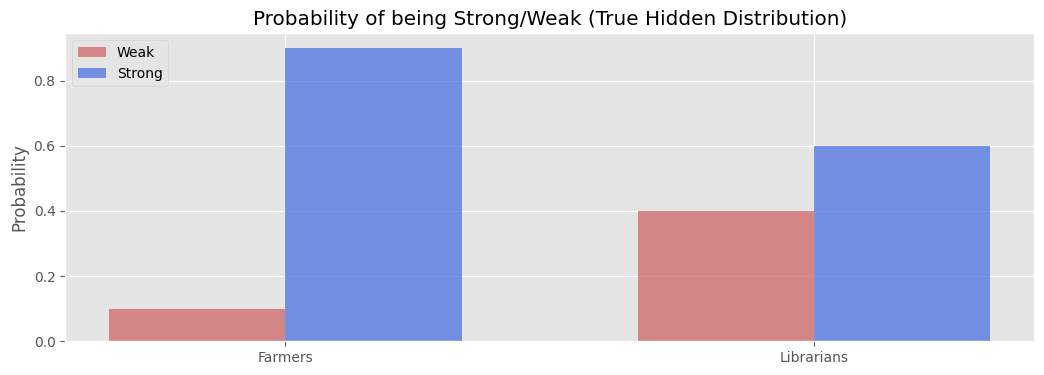

In [9]:
# Our Simple Visualization
plt.figure(figsize=(12.5, 4))
plt.bar([0.00, 0.75], likelihood_weak, alpha=0.70, width=0.25, color='IndianRed', lw=3)
plt.bar([0.25, 1.00], likelihood_strong, alpha=0.7, width=0.25, color='RoyalBlue', lw=3)

plt.xticks([0.125, 0.875], ["Farmers", "Librarians"])
plt.title(r"Probability of being Strong/Weak (True Hidden Distribution)")
plt.ylabel("Probability")
plt.legend(["Weak", "Strong"], loc="upper left");

$$P(\text{Librarian} | \text{Weak}) = P(\text{Weak} | \text{Librarian}) \frac{P(\text{Librarian})}{P(\text{Weak})}$$

The reasoning above seems correct, but it completely misses the fact that there are a lot more farmers than there are librarians. If we had no information of the person's attributes, and we had to take a wild guess, we would be a lot better off guessing farmer. Does this go out the window when we know one miniscule attribute?

No, we should continue to take it into account, and this idea is at the heart of Bayesianism. This value, the initial guess before we had any information is called the **Prior**.

### How the Prior changes things

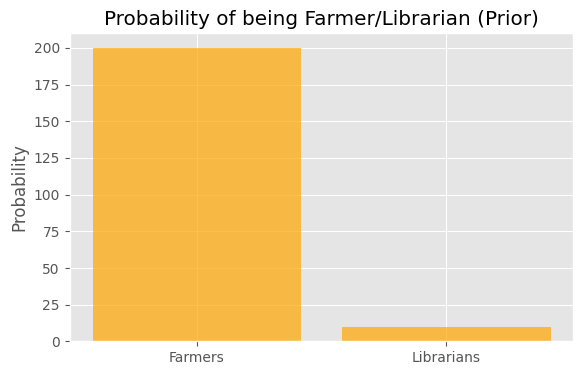

In [10]:
plt.figure(figsize=(6.5, 4))
plt.bar([0.25, 0.55], [total_farmers, total_librarians], alpha=0.7, width=0.25, color='Orange', lw=3)
plt.xticks([0.25, 0.55], ["Farmers", "Librarians"])

plt.title(r"Probability of being Farmer/Librarian (Prior)")
plt.ylabel("Probability")
plt.show()

Now that we take the prior into account, we multiply it to our evidence, and normalize the distribution so that the total probability is 1, we get our **posterior distribution**. This is the true model that we need to have. Now we see that the probability of this person being a librarian is higher than when we had no information, but it's still lower than being a farmer.

This seems to be a realistic estimate, and this the core essence of the discussion that will ensue in this module.

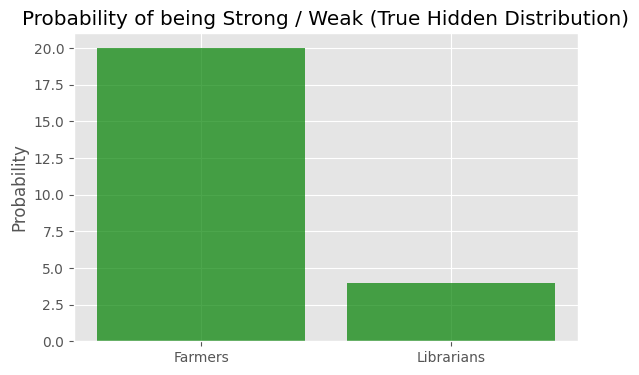

In [11]:
plt.figure(figsize=(6.5, 4))
plt.bar([0.25, 0.55], [weak_farmers, weak_librarians], alpha=0.7, width=0.25, color='Green', lw=3)
plt.xticks([0.25, 0.55], ["Farmers", "Librarians"])

plt.title(r"Probability of being Strong / Weak (True Hidden Distribution)")
plt.ylabel("Probability")
plt.show()

### Maximum Likelihood Estimate vs. Maximum A'posteriori Estimate

Believing that the person is a librarian based on the evidence alone is called the Maximum Likelihood Estimate of the problem.

Believing that the person is a farmer because you factored in prior probabilities is called the Maximum A'posteriori Estimate of the problem.

## Posterior Pulling - Is a coin truly fair?

You and your friend play cricket everyday, and you toss a coin to decide who bats. You are suspicious that your friend is cheating, so you want to use the observations of the toss everyday to conclude what the probability distribution over the tosses looks like.

* Start off with a Prior Distribution, either uniform, if you nothing about the coin yet, or something more biased, like you believe initially that the coin comes up heads more times than tails because your friend likes heads.
* Observe the result of the coin toss each day. Use this data to update your belief state

Let's first try to take a look at the probability function evolving in time. It initially starts off as our uniform prior and rapidly evolves into a stabler (not changing as much in time as it was initially) and sharper (more probability concentrated in less space).

### Live Example of Updates

In [ ]:
import math
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='jshtml')


def beta_pdf(x, a, b):
    return (x**(a-1) * (1-x)**(b-1) * math.gamma(a + b)
            / (math.gamma(a) * math.gamma(b)))

class UpdateDist:

    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.prob = prob
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='black')

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            self.success = 0
            self.line.set_data([], [])
            return self.line,

        # Choose success based on exceed a threshold with a uniform pick
        if np.random.rand(1,) < self.prob:
            self.success += 1
        y = beta_pdf(self.x, self.success + 1, (i - self.success) + 1)
        self.line.set_data(self.x, y)
        return self.line,


fig, ax = plt.subplots()
ud = UpdateDist(ax, prob=0.7)
anim = FuncAnimation(fig, ud, frames=100, interval=200, blit=True)

anim

### Trying out with different priors and different realities

Now it's time for more subtle analysis. We need to see how the prior affects the rate at which our model converges, and what are the states when we have less data.

**Bayesian Machine Learning is one of the best tools available in situations where we have very little data**.

In [13]:
def plot_evolution(p_heads_real, prior_strength, p_heads_init, color='RoyalBlue'):

    # Initialize our Prior, and draw 2000 samples from it
    num_trials = tf.constant([0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])
    prior = tfp.distributions.Bernoulli(probs=p_heads_real, dtype=tf.int32)
    samples = tf.pad(prior.sample(num_trials[-1]), tf.constant([[1, 0,]]),"CONSTANT")

    # Compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trials intervals
    cumulative_headcounts = tf.gather(tf.cumsum(samples), num_trials)

    # Update the belief state, which is the posterior (we are using a Beta function to store our belief, this can be change)
    rv_observed_heads = tfp.distributions.Beta(
        concentration1=tf.cast(int(prior_strength * p_heads_init) + cumulative_headcounts, tf.float32),
        concentration0=tf.cast(int(prior_strength * (1 - p_heads_init)) + num_trials - cumulative_headcounts, tf.float32))

    # Prepare the probability density function is a form that we can plot it
    probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
    observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))

    # Go ahead and Plot the functions
    plt.figure(figsize=(12, 30))
    for i in range(len(num_trials)):
        sx = plt.subplot(len(num_trials), 1, i+1)
        plt.xlabel("$f$, fraction of heads")
        plt.ylabel("$p(f)$, probability")
        plt.setp(sx.get_yticklabels(), visible=False)
        plt.plot(probs_of_heads, observed_probs_heads[i], label="%d tosses\n%d heads\n%d tails " % (
            num_trials[i], num_trials[i] - cumulative_headcounts[i], cumulative_headcounts[i]), color=color)
        plt.fill_between(probs_of_heads, 0, observed_probs_heads[i],  color=color, alpha=0.4)
        plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
        plt.legend().get_frame().set_alpha(0.4)
        plt.autoscale(tight=True)
    plt.suptitle("Bayesian updating of posterior probabilities\nFair coin starting from Uniform Prior", y=1.02, fontsize=14)
    plt.tight_layout()

First, let's assume that our friend is cheating, he really is not. Here, you can see how our distribution is skewed at the start, but slowly evolves to being fair as we collect more data. When we have less data, Bayes rule incorporates our biases.

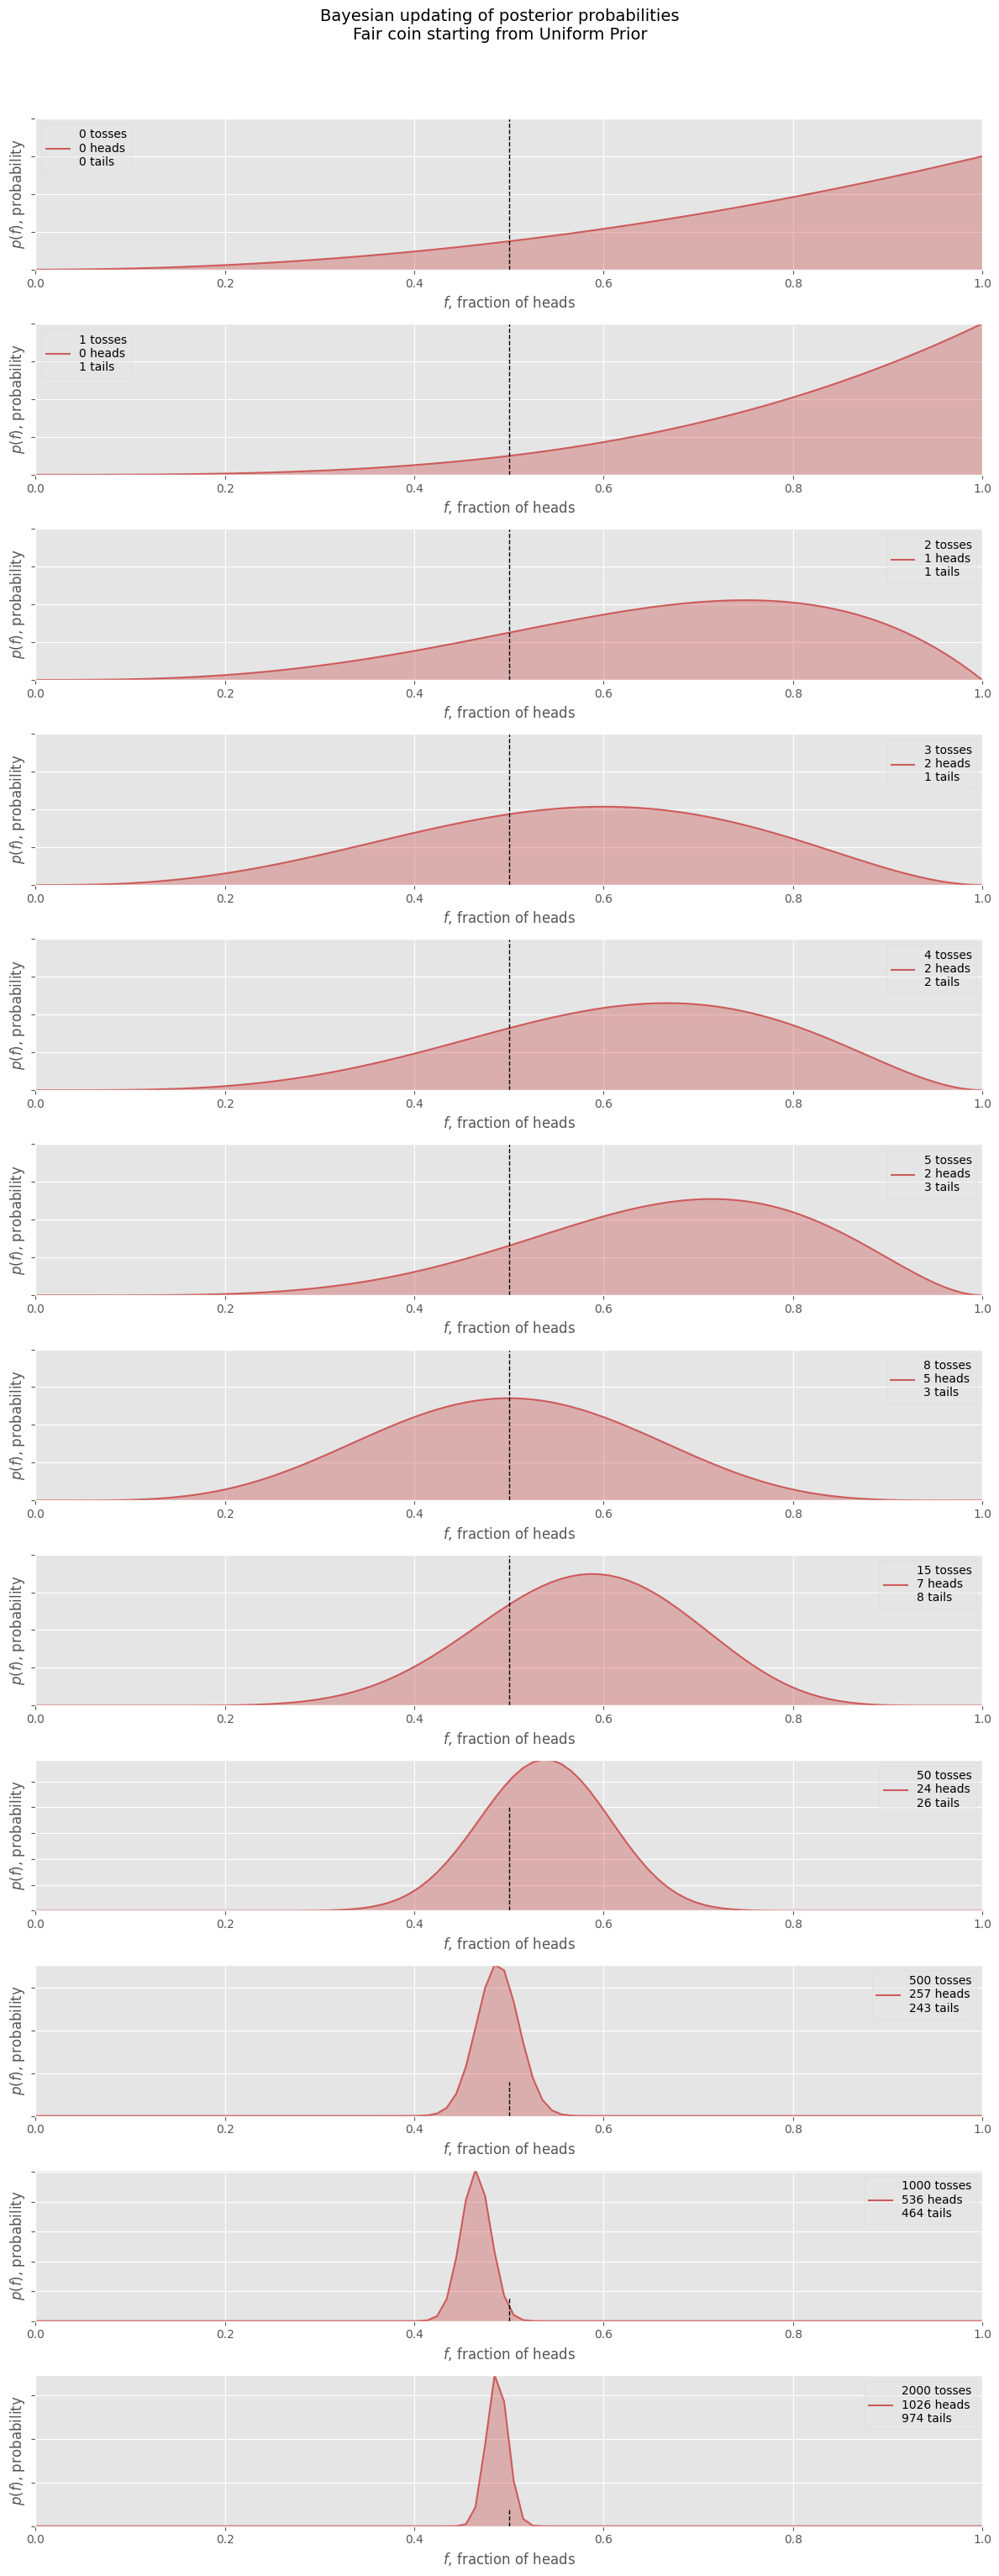

In [14]:
plot_evolution(0.5, 4.0, 0.75, "IndianRed")

Next we take a case where we are confidet that it's a fair toss, and it is indeed a fair toss. The confidence is reasonable. We expect the percentage of heads to be 50 with max probability.

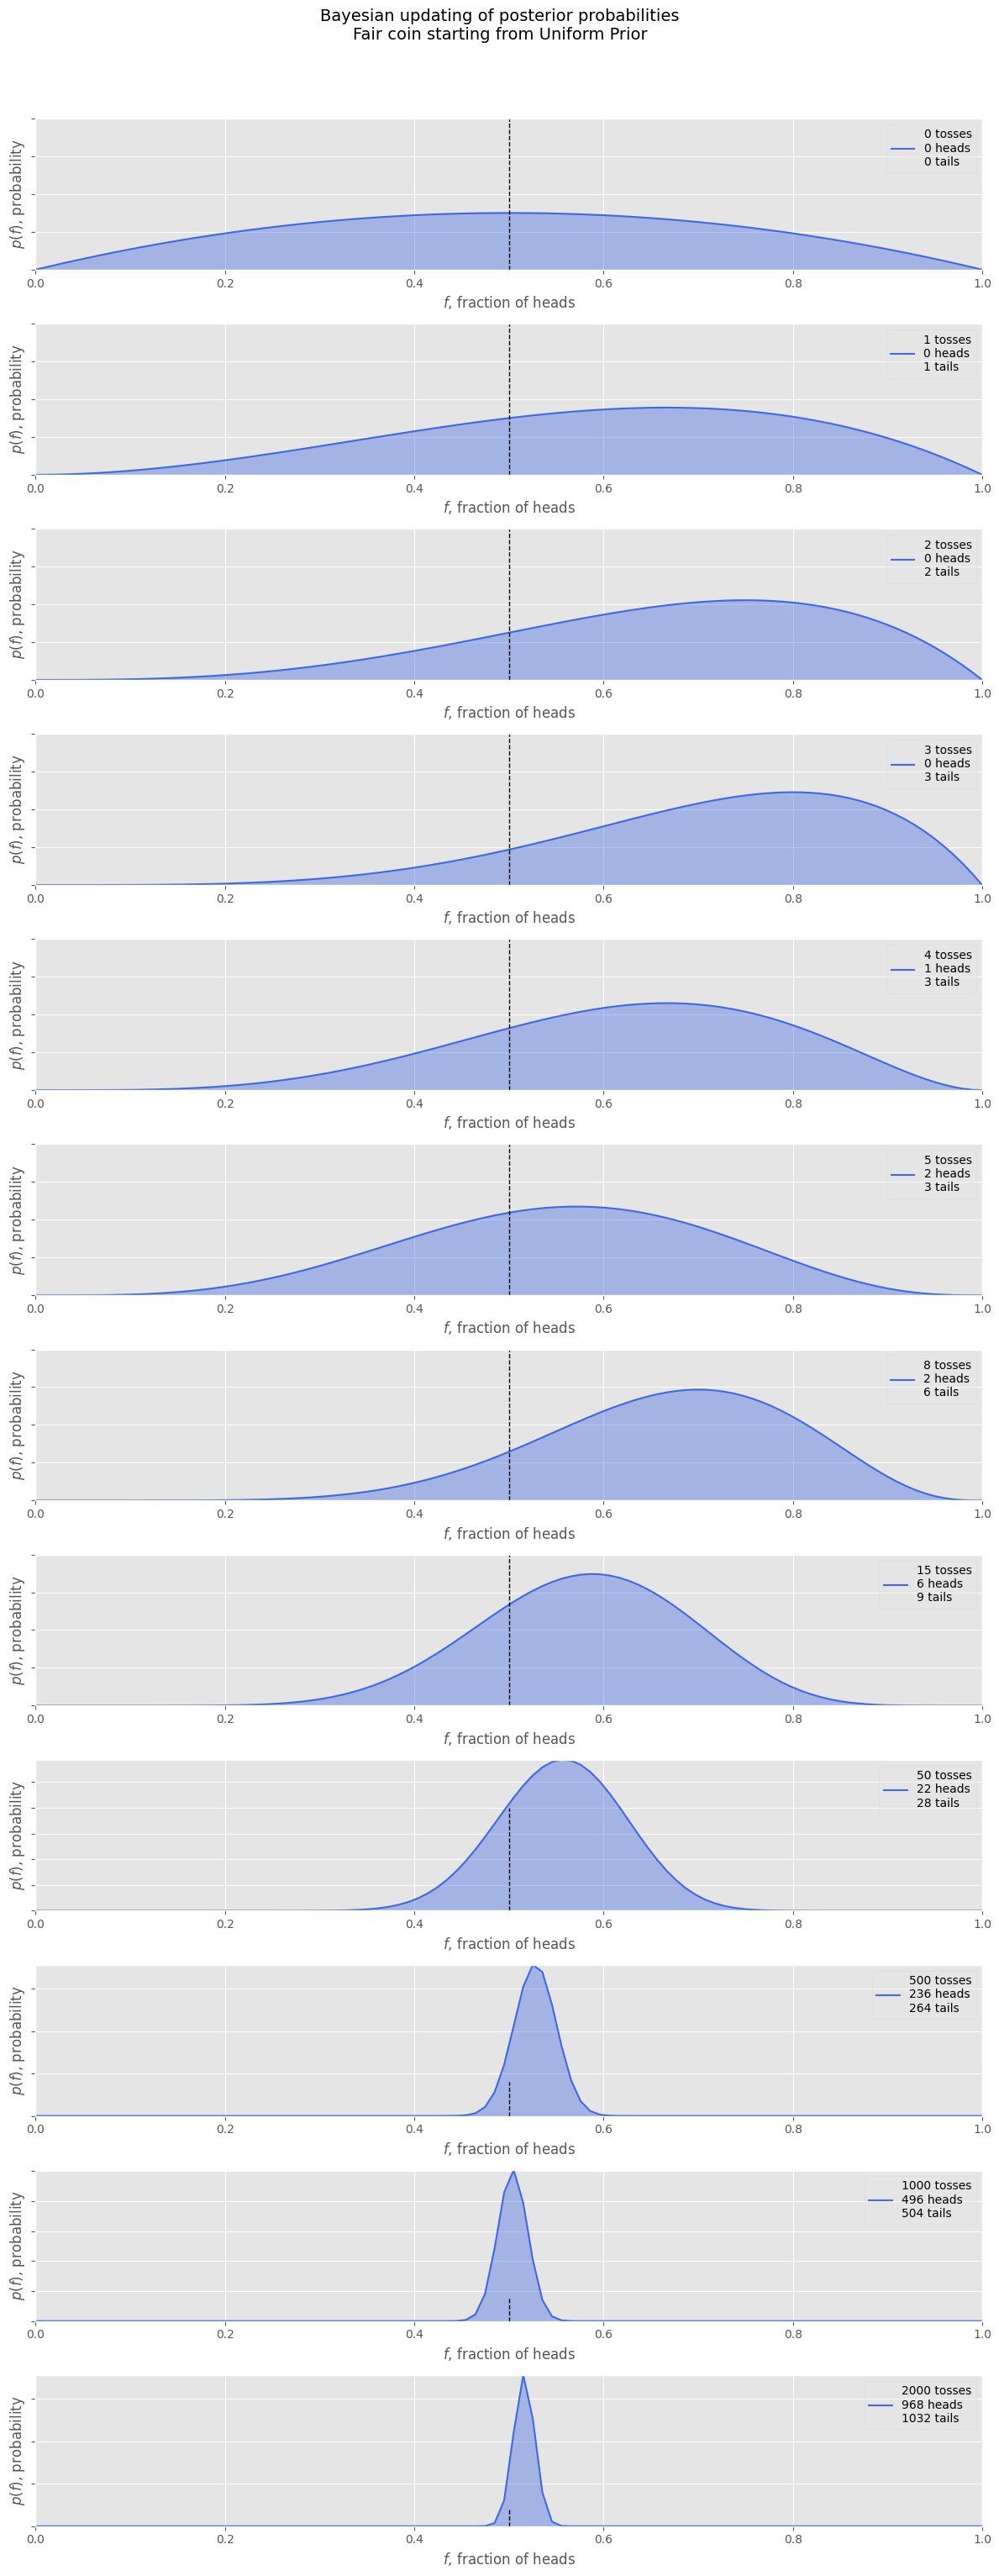

In [15]:
plot_evolution(0.5, 4.0, 0.5, "RoyalBlue")

The next experiment stats with the **belief that you the coin is more probably fair than biased**. The probability of the fraction of heads being 0.5 is highest in your prior. However, the reality is that your friend is cheating, the **coin does turn up heads more often**.

You notice that this time, that the form of the belief state initially makes more sense. This prior may make slightly more sense that the uniform prior.

In [ ]:
plot_evolution(0.75, 4.0, 0.5, "Orange")

In [ ]:
plot_evolution(0.75, 4.0, 0.75, "LimeGreen")